In [2]:
import pandas as pd
import numpy as np
from bcb import sgs
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from scipy.optimize import curve_fit
from sklearn import linear_model

In [37]:
def absolute(serie):
    valor_atual = 1598.41
    yield valor_atual
    for valor in serie[1:]:
        valor = valor / 100
        valor_atual += (valor_atual * valor)
        yield valor_atual

def months_until_next_election(date_serie):
    for date in date_serie:
        year = date.year
        years_until_next_election = abs(((year - 2) % 4) - 4)
        if years_until_next_election == 4:
            if date <= pd.to_datetime(f'{year}-10-01'):
                years_until_next_election = 0
        days_until_october = (pd.to_datetime(f'{year}-10-01') - date).days
        yield int((days_until_october + (365 * years_until_next_election)) / 30.5)

def get_indicators(start_date):
    selic = sgs.get(('SELIC',432),start = start_date)
    emprego = sgs.get(('emprego',28763),start = start_date)
    dataframe = emprego.copy()
    dataframe['emprego'] = dataframe['emprego'] / 100000000
    dataframe['SELIC'] = selic['SELIC'] / 100
    return dataframe

<AxesSubplot:xlabel='Date'>

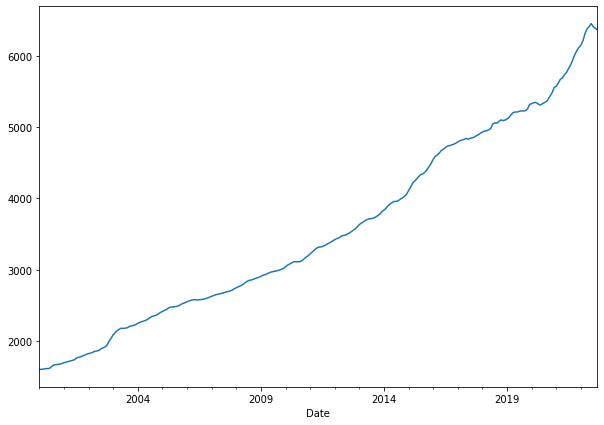

In [38]:
ipca = sgs.get(('IPCA',433),start = '2000-01-01')
ipca = ipca.iloc[:-1]
ipca['indice'] = [valor for valor in absolute(ipca['IPCA'].values)]
del(ipca['IPCA'])
# ipca['m_to_election'] = [valor for valor in months_until_next_election(ipca.index)]

df = get_indicators('2000-01-01')
df = df.iloc[:-1]

ipca.indice.plot(figsize = (10, 7))

In [12]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sktime.forecasting.arima import AutoARIMA
from pyGRNN import GRNN

In [14]:
def square(x,a,b,c):
    return ((x ** 2) * a) + (x * b) + c

def linear(x,a,b):
    return (x * a) + b

def untrend(serie):
    data = pd.DataFrame({'y':serie})
    x_values = np.arange(len(serie))
    popt = curve_fit(square,x_values,serie)[0]
    data['trend'] = [square(x,*popt) for x in x_values]
    data['no_trend'] = data['y'] - data['trend']
    return data['no_trend'].values

def train_test_split(xdata,ydata,horizonte):
    meses = horizonte * 12
    y_train,y_test = ydata.values[:-meses],ydata.values[-meses:]
    x_train,x_test = xdata.values[-meses - len(y_train):-meses],xdata.values[-meses:]
    return x_train,y_train.ravel(),x_test,y_test.ravel()

class base_model:
    def __init__(self,data,func):
        self.data = data
        self.func = func
    def fit(self):
        y = self.data
        self.popt = curve_fit(self.func,list(range(len(y))),y)[0]
        self.x0 = len(y)
        self.last_y = y[-1]
        return self
    def predict(self,n):
        prediction = np.array([self.func(x,*self.popt) for x in range(self.x0,self.x0 + n)])
        diferenca = prediction[0] - self.last_y
        return prediction - diferenca

class modelo:
    def __init__(self,name,ydata,xdata = None):
        self.name = name
        if name == 'holt':
            self.model = ExponentialSmoothing(ydata,seasonal_periods = 12,trend = "add",seasonal = "add").fit(0,0,0)
        if name == 'arima':
            self.model = AutoARIMA(sp = 12,suppress_warnings = True).fit(ydata)
        if self.name == 'grnn':
            self.model = GRNN().fit(xdata,ydata)

    def predict(self,n = None,data = None):
        if self.name == 'holt':
            return self.model.forecast(n)
        if self.name == 'arima':
            return self.model.predict(fh = list(range(1,n + 1))).ravel()
        if self.name == 'grnn':
            return self.model.predict(data)

class GodModel:
    def __init__(self,func,modelo,peso = 0.5):
        self.peso = peso
        self.func = func
        self.name = modelo
    
    def fit(self,target_data,extra_data,time_features = None):
        # Regressão linear das features secundarias
        self.reg = linear_model.LinearRegression()
        self.reg.fit(extra_data,target_data)
        # Regressão polinomial no tempo
        self.x0 = len(target_data)
        self.features = range(len(extra_data[0]))
        self.popts = [curve_fit(square,list(range(self.x0)),extra_data[:,i])[0] for i in self.features]
        self.popts_main = curve_fit(self.func,list(range(self.x0)),target_data)[0]
        # Sazonalidade
        untrended = untrend(target_data)
        self.model = modelo(self.name,untrended,time_features)
        self.target_data = target_data
        self.extra_data = extra_data
        return self

    def predict(self,n,time_features = None):
        self.predictions = []
        for i in self.features:
            popt = self.popts[i]
            prediction = np.array([square(x,*popt) for x in range(self.x0,self.x0 + n)])
            partial_last_year_mean = self.extra_data[-12:,i].mean()
            diferenca = partial_last_year_mean - prediction[0]
            prediction = prediction + diferenca
            self.predictions.append(prediction)
        main_prediction = np.array([self.func(x,*self.popts_main) for x in range(self.x0,self.x0 + n)])
        predictores = np.array(self.predictions).T
        feat_prediction = self.reg.predict(predictores)
        trend = (main_prediction * self.peso) + (feat_prediction * (1 - self.peso))
        seasonality = self.model.predict(n,time_features)
        prediction_final = trend + seasonality
        # Ajustes finais
        last_year_mean = self.target_data[-12:].mean()
        diferenca = last_year_mean - prediction_final[0]
        prediction_final = prediction_final + diferenca
        micro_diferenca = self.target_data[-1] - prediction_final[0]
        prediction_final = np.array([prediction_final[i] + (micro_diferenca * (1 - (i / (len(prediction_final) - 1)))) for i in range(len(prediction_final))])
        return prediction_final

MSE: 22558.953370555282
RMSE: 150.19638268132587


<AxesSubplot:xlabel='Date'>

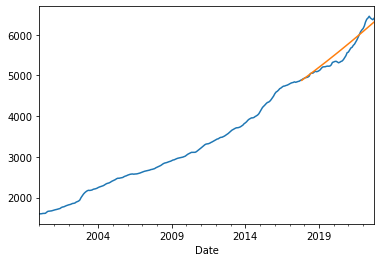

In [15]:
anos = 5
func = square
y_train,y_test = ipca['indice'].iloc[:-anos * 12].values,ipca['indice'].iloc[-anos * 12:].values
model = base_model(y_train,func).fit()
prediction = model.predict(12 * anos)
print('MSE:',mean_squared_error(prediction,y_test))
print('RMSE:',rmse(prediction,y_test))
pred_df = ipca.copy()
pred_df['prediction'] = [None for _ in range(len(pred_df) - len(prediction))] + list(prediction.ravel())
pred_df['indice'].plot()
pred_df['prediction'].plot()

MSE: 21916.63641479865
RMSE: 148.0426844352623


<AxesSubplot:xlabel='Date'>

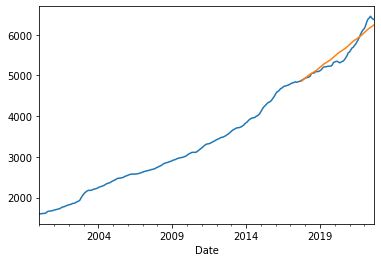

In [40]:
anos = 5
x_train,y_train,x_test,y_test = train_test_split(df,ipca['indice'],anos)
model = GodModel(square,'holt',1).fit(y_train,x_train)
prediction = model.predict(12 * anos)
print('MSE:',mean_squared_error(prediction,y_test))
print('RMSE:',rmse(prediction,y_test))
pred_df = ipca.copy()
pred_df['prediction'] = [None for _ in range(len(pred_df) - len(prediction))] + list(prediction.ravel())
pred_df['indice'].plot()
pred_df['prediction'].plot()